In [1]:
import pickle as pkl
import torch
from torch import nn
from easy_tpp.preprocess.event_tokenizer import EventTokenizer
from easy_tpp.config_factory import DataSpecConfig
from models.encoders.gru import GRUTPPEncoder
from models.decoders.rmtpp import RMTPPDecoder, RMTPPLoss
from models import TPPModel

In [2]:
def prepare_data(raw_data, config):
    # Validate input
    if not raw_data:
        raise ValueError("Input data is empty")
        
    tokenizer = EventTokenizer(config)
    tokenizer.padding_side = 'right'

    # Create input data dictionary
    input_data = {
        'time_seqs': [[x["time_since_start"] for x in seq] for seq in raw_data],
        'type_seqs': [[x["type_event"] for x in seq] for seq in raw_data],
        'time_delta_seqs': [[x["time_since_last_event"] for x in seq] for seq in raw_data]
    }
    
    # Filter and validate sequences
    filtered_data = {
        k: [seq for seq in v if len(seq) > 0]
        for k, v in input_data.items()
    }
    
    # Check if we have any valid sequences after filtering
    if not filtered_data['type_seqs']:
        raise ValueError("No valid sequences found after filtering (all sequences were empty)")
        
    # Get sequence lengths
    sequence_length = torch.tensor([len(seq) for seq in filtered_data['type_seqs']])
    
    # Add debug logging
    print(f"Pre-padding shapes:")
    for k, v in filtered_data.items():
        print(f"{k}: {len(v)} sequences")
        
    # Pad sequences    
    batch = tokenizer.pad(filtered_data, 
                         return_tensors='pt',
                         return_attention_mask=None,
                         padding='longest')
                         
    batch['sequence_length'] = sequence_length
    
    print(f"Final batch size: {len(batch['type_seqs'])}")
    
    return batch

In [3]:
dev_dict = pkl.load(open('data/earthquake/dev.pkl', 'rb'))
test_dict = pkl.load(open('data/earthquake/test.pkl', 'rb'))
train_dict = pkl.load(open('data/earthquake/train.pkl', 'rb'))

dim_process = train_dict['dim_process']
config = DataSpecConfig.parse_from_yaml_config({
    'num_event_types': dim_process,
    'pad_token_id': dim_process
})

In [4]:
HIDDEN_DIM = 128
MLP_DIM = 64
device = 'cpu' if not torch.cuda.is_available() else 'cuda'
train_data = train_dict['train']
processed_data = prepare_data(train_data, config).to(device)
model = TPPModel(config, hidden_dim=HIDDEN_DIM, mlp_dim=MLP_DIM, device=device).to(device)

# print sizes of each time_seqs 
print("Time Seqs Sizes:", processed_data['time_seqs'].size())
decoder_output = model(processed_data)
time_loss, mark_loss, total_loss = model.compute_loss(processed_data, decoder_output)

print("Time Loss:", time_loss.item())
print("Mark Loss:", mark_loss.item())
print("Total Loss:", total_loss.item())

Pre-padding shapes:
time_seqs: 3000 sequences
type_seqs: 3000 sequences
time_delta_seqs: 3000 sequences
Final batch size: 3000
Time Seqs Sizes: torch.Size([3000, 18])
Time Loss: 1.3547415733337402
Mark Loss: 1.9339760541915894
Total Loss: 3.288717746734619


In [5]:
test_data = test_dict['test']
processed_test_data = prepare_data(test_data, config)
model.eval()
processed_test_data = {k: v.to(device) for k, v in processed_test_data.items()}

with torch.no_grad():
    test_decoder_output = model(processed_test_data)
    test_time_loss, test_mark_loss, test_total_loss = model.compute_loss(processed_test_data, test_decoder_output)

print("Test Time Loss:", test_time_loss.item())
print("Test Mark Loss:", test_mark_loss.item())
print("Test Total Loss:", test_total_loss.item())

Pre-padding shapes:
time_seqs: 896 sequences
type_seqs: 896 sequences
time_delta_seqs: 896 sequences
Final batch size: 896
Test Time Loss: 0.9131205081939697
Test Mark Loss: 1.9402457475662231
Test Total Loss: 2.8533663749694824


In [6]:
# Print all shapes of the sequences
print("Time Seqs Sizes:", processed_data['time_seqs'].size())

Time Seqs Sizes: torch.Size([3000, 18])


In [ ]:
from torch.utils.data import DataLoader, Dataset

# class EventDataset(Dataset):
#     def __init__(self, data):
#         self.data = data        

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         return self.data[idx]

class EventDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data['type_seqs'])

    def __getitem__(self, idx):
        return {
            'time_seqs': self.data['time_seqs'][idx],
            'type_seqs': self.data['type_seqs'][idx],
            'time_delta_seqs': self.data['time_delta_seqs'][idx],
            'sequence_length': self.data['sequence_length'][idx]
        }

# Create datasets
# train_dataset = EventDataset(train_data)
# test_dataset = EventDataset(test_data)
train_dataset = EventDataset(processed_data)
test_dataset = EventDataset(processed_test_data)

# Create data loaders with collate function and arguments to prepare_data
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda batch: prepare_data(batch, config))
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=lambda batch: prepare_data(batch, config), drop_last=False)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

# Training loop
num_epochs = 200
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        optimizer.zero_grad()
        decoder_output = model(batch)
        time_loss, mark_loss, total_loss = model.compute_loss(batch, decoder_output)
        total_loss.backward()
        optimizer.step()
        total_train_loss += total_loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}")

    # Evaluate on test data
    model.eval()
    total_test_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            decoder_output = model(batch)
            _, _, total_loss = model.compute_loss(batch, decoder_output)
            total_test_loss += total_loss.item()

    avg_test_loss = total_test_loss / len(test_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Test Loss: {avg_test_loss:.4f}")

Epoch 1/100, Train Loss: 2.3879
Epoch 1/100, Test Loss: 1.1920
Epoch 2/100, Train Loss: 0.9864
Epoch 2/100, Test Loss: 0.2105
Epoch 3/100, Train Loss: 0.4263
Epoch 3/100, Test Loss: -0.1728
Epoch 4/100, Train Loss: 0.1659
Epoch 4/100, Test Loss: -0.3558
Epoch 5/100, Train Loss: 0.0026
Epoch 5/100, Test Loss: -0.5244
Epoch 6/100, Train Loss: -0.1414
Epoch 6/100, Test Loss: -0.6640
Epoch 7/100, Train Loss: -0.2667
Epoch 7/100, Test Loss: -0.7829
Epoch 8/100, Train Loss: -0.3850
Epoch 8/100, Test Loss: -0.8907
Epoch 9/100, Train Loss: -0.5208
Epoch 9/100, Test Loss: -1.0227
Epoch 10/100, Train Loss: -0.6052
Epoch 10/100, Test Loss: -1.0711
Epoch 11/100, Train Loss: -0.7484
Epoch 11/100, Test Loss: -1.2395
Epoch 12/100, Train Loss: -0.8707
Epoch 12/100, Test Loss: -1.3353
Epoch 13/100, Train Loss: -0.9524
Epoch 13/100, Test Loss: -1.3852
Epoch 14/100, Train Loss: -0.9893
Epoch 14/100, Test Loss: -1.4250
Epoch 15/100, Train Loss: -0.9993
Epoch 15/100, Test Loss: -1.4197
Epoch 16/100, Train 

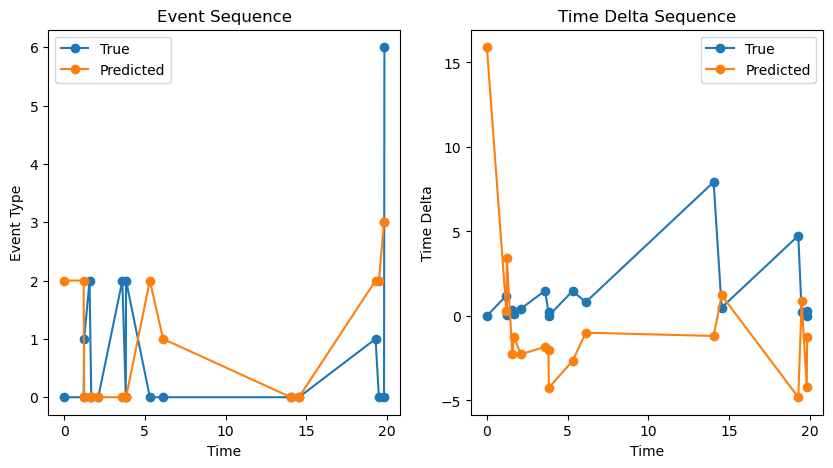

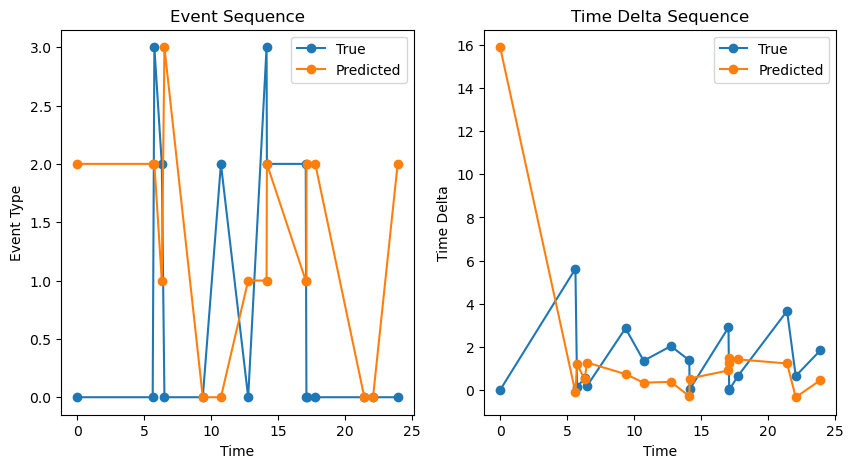

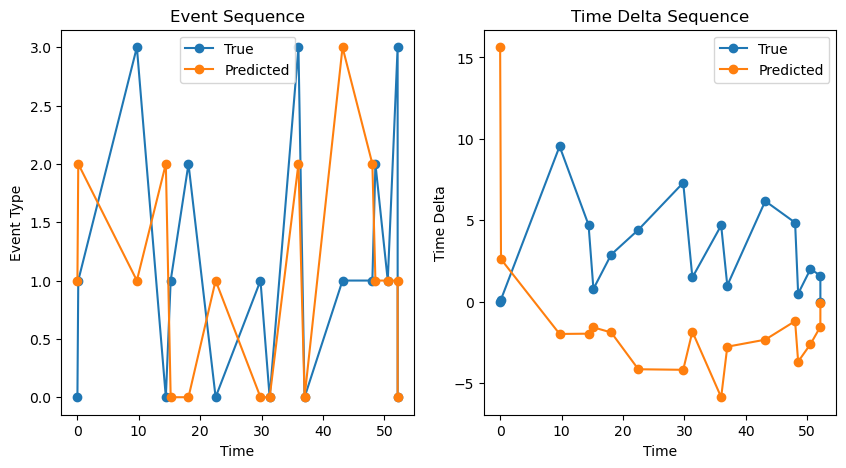

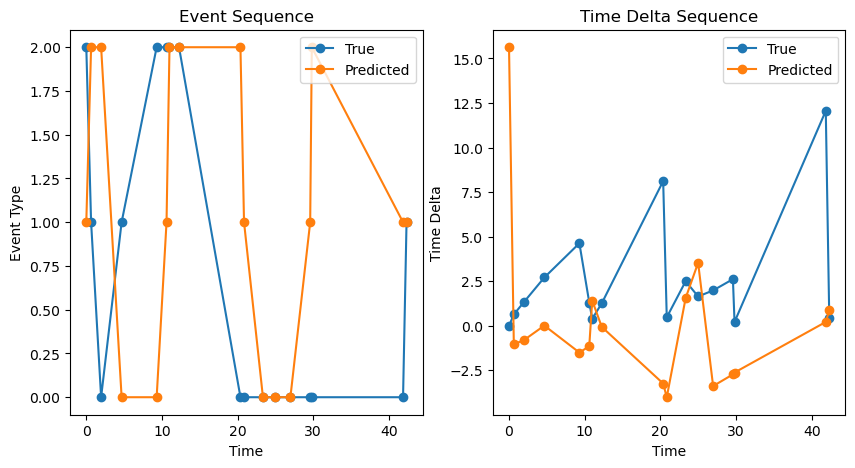

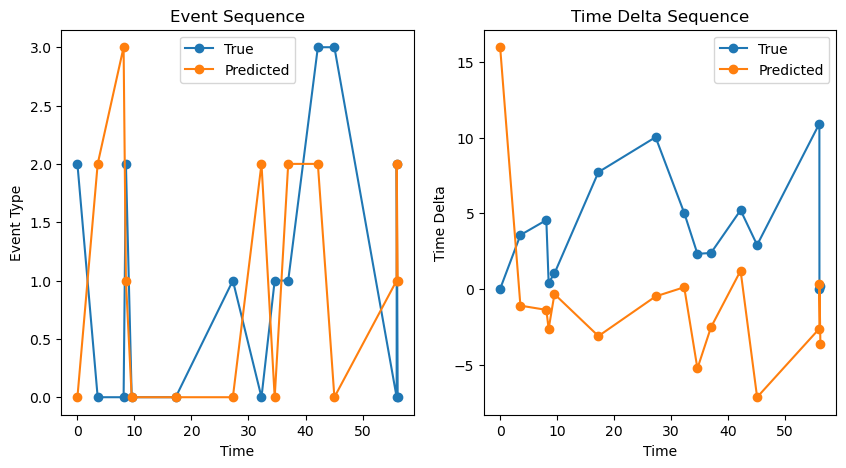

In [8]:
# plot the event sequences and the predicted event sequences
import numpy as np
import matplotlib.pyplot as plt

def plot_event_sequence(time_seqs, type_seqs, time_delta_seqs, sequence_length, decoder_output, num_samples=5):
    for i in range(num_samples):
        time_seq = time_seqs[i].cpu().numpy()
        type_seq = type_seqs[i].cpu().numpy()
        time_delta_seq = time_delta_seqs[i].cpu().numpy()
        seq_len = sequence_length[i].item()
        pred_time_delta_seq = decoder_output.time_output[i].cpu().numpy()
        pred_mark_logits = decoder_output.mark_logits[i].cpu().numpy()

        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.plot(time_seq[:seq_len], type_seq[:seq_len], 'o-', label='True')
        plt.plot(time_seq[:seq_len], np.argmax(pred_mark_logits[:seq_len], axis=-1), 'o-', label='Predicted')
        plt.xlabel('Time')
        plt.ylabel('Event Type')
        plt.title('Event Sequence')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(time_seq[:seq_len], time_delta_seq[:seq_len], 'o-', label='True')
        plt.plot(time_seq[:seq_len], pred_time_delta_seq[:seq_len], 'o-', label='Predicted')
        plt.xlabel('Time')
        plt.ylabel('Time Delta')
        plt.title('Time Delta Sequence')
        plt.legend()

        plt.show()
        
plot_event_sequence(processed_data['time_seqs'], processed_data['type_seqs'], processed_data['time_delta_seqs'], processed_data['sequence_length'], decoder_output)


In [9]:
# class DecoderOutput(NamedTuple):
#     """Container for decoder outputs to make the interface cleaner"""

#     time_delta: torch.Tensor  # Predicted time delta
#     mark_logits: torch.Tensor  # Log probabilities for marks
#     intensity_integral: torch.Tensor  # Integral of intensity function
#     base_intensity: torch.Tensor  # Base intensity values
